# Parallelization with Python
To learn parallelization, we do a simple maximisation 

\begin{eqnarray}
\max_c \quad  log(c)  \\\
\text{s.t.} \quad c \leq w
\end{eqnarray}

Clearly the solution is to consume all your income. Lets check how fast the computer can find this solution when we search over a grid using
1. a python loop;
2. a JIT (just in time compilation) numba loop;
3. a parallel (multi-threaded) loop with numba;
4. vectorization (i.e. maximization over every row in a matrix) with numpy;
5. gpu vectorization with cupy. 

Note that numpy is pythons matlab-like library for dealing with matrices. Cupy is a gpu version of numpy, so it is like the gpuArray that we used with matlab.  

I find that the GPU is fastest, followed by Numba Parallel, Numba non-parallel, Numpy vectorization, and a python loop. The scores below show that it is worth testing your code for speed. While the scores are close for this problem, they can be much bigger for more complicated problems. 

In [30]:
import numpy as np
from numba import njit, vectorize, float64, prange, int64, threading_layer
import cupy as cp
import time
import matplotlib.pyplot as plt

In [31]:
N_state = 10000
x_grid = np.linspace(0.01,10,N_state)
choice = np.tile(x_grid,[N_state,1])
choice.shape
utility = np.zeros((N_state,N_state))

max_utility_loop = np.zeros((N_state,N_state))
max_index_loop =  np.zeros((N_state,N_state), dtype=int)

@vectorize([float64(float64)])
def u(x):
    return np.log(x)

In [32]:
utility = u(choice) 
utility = np.where(choice>choice.T, -100 ,utility)
print(utility[0:5,0:5])


[[  -4.60517019 -100.         -100.         -100.         -100.        ]
 [  -4.60517019   -4.50994184 -100.         -100.         -100.        ]
 [  -4.60517019   -4.50994184   -4.42299866 -100.         -100.        ]
 [  -4.60517019   -4.50994184   -4.42299866   -4.34301366 -100.        ]
 [  -4.60517019   -4.50994184   -4.42299866   -4.34301366   -4.26895515]]


In [33]:
# create gpu array of utility
utility_gpu =  cp.asarray(utility) 

# Compute maximum
## Numpy vectorization

In [34]:
# compute maximum
print('CPU, vectorization with numpy: ')
start = time.time()
max_utility_index = np.argmax(utility,1)
#max_utility = np.take_along_axis( utility, np.expand_dims(max_utility_index, axis=1), axis=1)
max_utility = np.max(utility,1)

time_cpu = time.time()- start
print(time_cpu)


CPU, vectorization with numpy: 
0.24786067008972168


Text(0, 0.5, 'Income (state)')

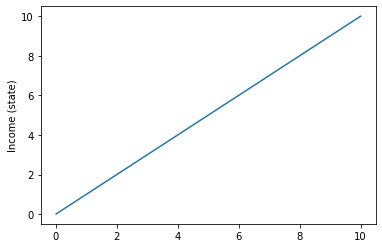

In [35]:
plt.plot(x_grid,x_grid[max_utility_index])
plt.ylabel('Choice')
plt.ylabel('Income (state)')

## Python loop

In [36]:
print('CPU: loop')
start = time.time()
for i in range(N_state):
    max_utility_index[i] = np.argmax(utility[i,:])
    max_utility[i] = np.max(utility[i,:])
    
time_cpu_loop = time.time()- start
print(time_cpu_loop)

CPU: loop
0.2866072654724121


Interestingly in this example the loop isn't too slow. 

## Numba JIT loop and parallization

In [37]:
@njit
def loop_numba(N_state,utility,max_index_loop,max_utility_loop):
    for i in range(N_state):       
        max_utility_loop[i] = np.max( utility[i,:])
        max_index_loop[i] = np.argmax(utility[i,:])
    return  max_index_loop ,max_utility_loop

@njit(parallel=True)
def loop_numba_parallel(N_state,utility,max_index_loop,max_utility_loop):
    for i in prange(N_state):       
        max_utility_loop[i] = np.max(utility[i,:])
        max_index_loop[i] = np.argmax(utility[i,:])
    return  max_index_loop ,max_utility_loop


In [39]:
max_utility_loop = np.zeros((N_state))
max_index_loop =  np.zeros((N_state), dtype=int)
print('CPU: numba')
start = time.time()
max_index_numba  =  loop_numba(N_state,utility,max_index_loop,max_utility_loop)
time_cpu_numba = time.time()- start
print(time_cpu_numba)

print()
print('CPU: numba parallel')
start = time.time()
max_index_numba  =  loop_numba_parallel(N_state,utility,max_index_loop,max_utility_loop)
time_cpu_numba_par = time.time()- start
print(time_cpu_numba_par)

CPU: numba
0.22082257270812988

CPU: numba parallel
0.050853729248046875


Note: since the first run includes the costly compilation step, we should run this again to find the speed it would take if we repeatedly called these functions. 

## GPU vectorization

In [40]:
# compute maximum
print('GPU: ')
start_gpu = cp.cuda.Event()
end_gpu = cp.cuda.Event()

start_gpu.record()
max_utility_index_gpu = cp.argmax(utility_gpu,axis=1)
#max_utility_gpu = cp.take_along_axis( utility, cp.expand_dims(max_utility_index_gpu, axis=1), axis=1)

end_gpu.record()
end_gpu.synchronize()
time_gpu = cp.cuda.get_elapsed_time(start_gpu, end_gpu)
print(0.001*time_gpu)

GPU: 
0.018231231689453127


## Comparing speeds

In [43]:
print('speedup Numba parallel (vs python loop)')
print(time_cpu_loop/time_cpu_numba_par)
print('')
print('speedup GPU (vs numba CPU parallel)')
print(time_cpu_numba_par/(0.001*time_gpu))
print('')
print('speedup GPU (vs python loop)')
print(time_cpu_loop/(0.001*time_gpu))

speedup Numba parallel (vs python loop)
5.635914410021754

speedup GPU (vs numba CPU parallel)
2.7893743063704277

speedup GPU (vs python loop)
15.720674848217527
